In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import transforms
from torchvision.io import read_image
from torch.utils.data import Dataset, DataLoader,random_split
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import os
import pandas as pd

# 1. 自定义数据集类

In [2]:
class HandwrittenDigitsDataset(Dataset):
    def __init__(self, img_dir, annotations_dir, transform=None):
        self.img_names = [img for img in os.listdir(img_dir) if img.endswith('.jpg')]
        self.img_dir = img_dir
        self.annotations_dir = annotations_dir
        self.transform = transform

    def __len__(self):
        return len(self.img_names)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_names[idx])
        image = read_image(img_path).float()  # 这里已经是Tensor了
        if self.transform:
            image = self.transform(image)  # 确保transform不包含ToTensor()

        # 加载注释并构造目标字典
        annotation_file = os.path.join(self.annotations_dir, f"{idx+1}.txt")
        boxes, labels = self.read_annotation(annotation_file)
        
        targets = {}
        targets["boxes"] = torch.as_tensor(boxes, dtype=torch.float32)
        targets["labels"] = torch.as_tensor(labels, dtype=torch.int64)  

        return image, targets

    def read_annotation(self, file_path):
        annotations = []
        with open(file_path, 'r') as file:
            for line in file:
                annotations.append(list(map(int, line.split())))

        # 转换为 Tensor
        annotations = torch.tensor(annotations, dtype=torch.int64)
        # 分割标签和边界框
        labels = annotations[:, 0]
        boxes = annotations[:, 1:]
        # boxes[:,  2:4] = boxes[:,0:2] + boxes[:, 2:4]
        return boxes, labels


transform = transforms.Compose([
    transforms.Resize((48, 96), antialias=True),
    transforms.Normalize((0.5,), (0.5,))
])



# 2. 预处理图像数据

In [4]:
train_dataset = HandwrittenDigitsDataset(img_dir='../A+B/samples/inputs', annotations_dir='../A+B/samples/explanations', transform=transform)
# train_dataset 是您的完整训练数据集

train_size = int(0.8 * len(train_dataset))  # 80% 的数据用于训练
val_size = len(train_dataset) - train_size  # 20% 的数据用于验证
train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])
train_loader = DataLoader(train_dataset, batch_size=1024, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

print(f'len(train_dataset):{len(train_dataset)},train_size:{train_size},val_size:{val_size}')


len(train_dataset):1618,train_size:1618,val_size:405


In [5]:
# for images, targets in val_loader:
#     print(targets)
#     break  # 只打印第一批数据

# 3.模型定义

In [6]:
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.rpn import AnchorGenerator

def get_model(num_classes):
    # 加载预训练的模型
    model = fasterrcnn_resnet50_fpn(pretrained=True)
    # 获取分类器的输入特征数
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # 每个特征图层的锚框尺寸，每个特征图层的锚框长宽比
    anchor_sizes = ((16,), (32,), (64,), (128,), (256,))
    anchor_aspect_ratios = ((0.5, 1.0, 2.0),) * len(anchor_sizes)
    anchor_generator = AnchorGenerator(sizes=anchor_sizes, aspect_ratios=anchor_aspect_ratios)
    model.rpn.anchor_generator = anchor_generator
    # 替换预训练的头部以适应新的类别数
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    model.transform.min_size = (48,)
    model.transform.max_size = 256
    return model

# 由于您的任务是检测数字，类别数设置为10（0-9）加一个背景类
model = get_model(num_classes=11)
# 将模型移到GPU
device = torch.device('cuda:2') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

/root/anaconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/root/anaconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(48,), max_size=256, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(in

# 4. 定义损失函数和优化器

In [7]:
# 优化器
optimizer = torch.optim.Adam(model.parameters(), lr=1.0e-4)
criterion = nn.CrossEntropyLoss()

In [26]:
from sklearn.metrics import precision_score, recall_score

def evaluate(model, val_loader, device):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, targets_list in val_loader:
            images = [img.to(device) for img in images]
            outputs = model(images)

            for i, output in enumerate(outputs):
                # 提取预测类别
                pred_labels = output['labels'].cpu().tolist()
                all_preds.extend(pred_labels)

                # 提取真实类别
                if 'labels' in targets_list[i]:
                    true_labels = targets_list[i]['labels'].type(torch.int64).cpu().tolist()
                    all_labels.extend(true_labels)
                else:
                    raise TypeError("Target is not a dictionary or doesn't have 'labels' key.")

    # 计算精确度和召回率
    precision = precision_score(all_labels, all_preds, average='weighted', zero_division=0)
    recall = recall_score(all_labels, all_preds, average='weighted', zero_division=0)

    return precision, recall




'''
def evaluate(model, val_loader, device):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for images, target_dict in val_loader:
            images = [image.to(device) for image in images]
            targets = [{k: v[i].to(device) for k, v in target_dict.items()} for i in range(len(images))]

            loss_dicts = model(images, targets)

            # 对每个图像的损失进行处理
            for loss_dict in loss_dicts:
                # 将所有损失转换为相同长度
                loss_lengths = [len(loss) for loss in loss_dict.values()]
                max_length = max(loss_lengths)
                
                # 如果损失长度不一致，则进行填充
                for key in loss_dict.keys():
                    if len(loss_dict[key]) < max_length:
                        padding = torch.zeros(max_length - len(loss_dict[key]), device=device)
                        loss_dict[key] = torch.cat((loss_dict[key], padding))
                
                # 计算图像的总损失
                image_loss = sum(loss.sum() for loss in loss_dict.values())
                total_loss += image_loss.item()

    # 计算平均损失
    return total_loss / len(val_loader)
'''

'\ndef evaluate(model, val_loader, device):\n    model.eval()\n    total_loss = 0\n    with torch.no_grad():\n        for images, target_dict in val_loader:\n            images = [image.to(device) for image in images]\n            targets = [{k: v[i].to(device) for k, v in target_dict.items()} for i in range(len(images))]\n\n            loss_dicts = model(images, targets)\n\n            # 对每个图像的损失进行处理\n            for loss_dict in loss_dicts:\n                # 将所有损失转换为相同长度\n                loss_lengths = [len(loss) for loss in loss_dict.values()]\n                max_length = max(loss_lengths)\n                \n                # 如果损失长度不一致，则进行填充\n                for key in loss_dict.keys():\n                    if len(loss_dict[key]) < max_length:\n                        padding = torch.zeros(max_length - len(loss_dict[key]), device=device)\n                        loss_dict[key] = torch.cat((loss_dict[key], padding))\n                \n                # 计算图像的总损失\n                ima

# 5. 编写训练循环

In [8]:
from tqdm.notebook import tqdm
num_epochs = 50
min_loss = float('inf')
pbar = tqdm(range(num_epochs), desc='Initializing')
# 初始化损失历史记录
loss_histories = {
    "loss_classifier": [],
    "loss_box_reg": [],
    "loss_objectness": [],
    "loss_rpn_box_reg": []
}
for epoch in pbar:
    # 训练模式
    model.train()
    train_losses = 0.0
    # 移除 torch.cuda.empty_cache() 或在必要时使用
    for images, target_dict in train_loader:
        images = [image.to(device) for image in images]
        targets = [{k: v[i].to(device) for k, v in target_dict.items()} for i in range(len(images))]
        
        optimizer.zero_grad()
        train_loss_dict = model(images, targets)
        # for _keys,_values in train_loss_dict.items():
        #     print(f"keys:{_keys}:{_values}")

        for loss_name in loss_histories.keys():
            loss_value = train_loss_dict[loss_name].item()
            loss_histories[loss_name].append(loss_value)

        current_loss = sum(loss for loss in train_loss_dict.values())
        current_loss.backward()
        optimizer.step()

        train_losses += current_loss.item()  # 累加每个批次的损失
    train_losses /= len(train_loader)  # 计算平均训练损失
    # validate 
    # val_loss,precision, recall= evaluate(model, val_loader, device)
    val_loss,precision, recall= 0.0,0.0,0.0
    # 仅在每个 epoch 结束时更新进度条描述
    pbar.set_description(f'Epoch [{epoch+1}/{num_epochs}], Loss: {train_losses:.4f},Val Loss: {val_loss:.4f},Precision:{precision},recall:{recall}')
    
    # 检查并保存最佳模型
    if train_losses < min_loss:
        min_loss = train_losses
        # 创建保存目录（如果不存在）
        save_dir = "model_weights"
        os.makedirs(save_dir, exist_ok=True)
        save_path = os.path.join(save_dir, f"lenet_best_model_epoch_{epoch+1}.pth")
        torch.save(model.state_dict(), save_path)
# 训练结束后保存最终模型
final_save_path = os.path.join(save_dir, "lenet_final_model.pth")
torch.save(model.state_dict(), final_save_path)

Initializing:   0%|          | 0/20 [00:00<?, ?it/s]

keys:loss_classifier:315.929931640625
keys:loss_box_reg:281.45904541015625
keys:loss_objectness:254.41268920898438
keys:loss_rpn_box_reg:3.1318278312683105
keys:loss_classifier:80.72932434082031
keys:loss_box_reg:116.24353790283203
keys:loss_objectness:13.164202690124512
keys:loss_rpn_box_reg:1.8705593347549438
keys:loss_classifier:64.40179443359375
keys:loss_box_reg:81.9325942993164
keys:loss_objectness:15.28142261505127
keys:loss_rpn_box_reg:1.4766595363616943
keys:loss_classifier:54.019290924072266
keys:loss_box_reg:60.453041076660156
keys:loss_objectness:6.364625453948975
keys:loss_rpn_box_reg:1.3207186460494995
keys:loss_classifier:35.6097412109375
keys:loss_box_reg:46.80824661254883
keys:loss_objectness:4.8201003074646
keys:loss_rpn_box_reg:1.2833175659179688
keys:loss_classifier:21.294233322143555
keys:loss_box_reg:32.489501953125
keys:loss_objectness:4.810794830322266
keys:loss_rpn_box_reg:1.1431610584259033
keys:loss_classifier:16.16702651977539
keys:loss_box_reg:24.0463638305

In [ ]:
# 训练结束后绘制损失图表
plt.figure(figsize=(12, 8))
for loss_name, values in loss_histories.items():
    plt.plot(values, label=loss_name)
plt.title('Training Losses')
plt.xlabel('Batch')
plt.ylabel('Loss')
plt.legend()
plt.show()

## 可视化展示

image shape:torch.Size([1, 48, 96])
image shape:torch.Size([1, 48, 96])


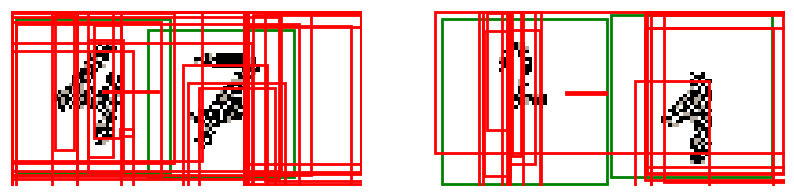

In [10]:
# origin version
import numpy as np
def visualize_predictions(model, val_loader, device, num_images=5):
    model.eval()  # 设置模型为评估模式
    images, target_dict = next(iter(val_loader))
    images = [image.to(device) for image in images]
    targets = [{k: v[i].to(device) for k, v in target_dict.items()} for i in range(len(images))]

    with torch.no_grad():
        predictions = model(images)
    
    # 选择要可视化的图像
    images = images[:num_images]
    predictions = predictions[:num_images]
    targets = targets[:num_images]

    return images, predictions, targets

# debugging
train_dataset = HandwrittenDigitsDataset(img_dir='../A+B/samples/inputs', annotations_dir='../A+B/samples/explanations', transform=transform)
train_loader = DataLoader(train_dataset, batch_size=2, shuffle=False)

# 获取一些图像和预测
images, predictions, targets = visualize_predictions(model, train_loader, device)
def show_image_with_boxes(image, target, prediction, ax):
    image = transform(image)
    print(f"image shape:{image.shape}")
    # 将张量图像转换为numpy格式
    image = image.cpu().numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    image = np.clip(image, 0, 1)

    ax.imshow(image)
    ax.axis('off')

    # 真实边界框
    for box in target['boxes'].cpu():
        rect = patches.Rectangle(
            (box[0], box[1]), box[2] - box[0], box[3] - box[1],
            linewidth=2, edgecolor='green', facecolor='none'
        )
        # print(f"blue:({box[0]},{box[1]}),({box[2] - box[0]},{box[3] - box[1]})")
        ax.add_patch(rect)

    # 预测边界框
    for box in prediction['boxes'].cpu():
        rect = patches.Rectangle(
            (box[0], box[1]), box[2] - box[0], box[3] - box[1],
            linewidth=2, edgecolor='red', facecolor='none'
        )
        # print(f"red:({box[0]},{box[1]}),({box[2] - box[0]},{box[3] - box[1]})")
        ax.add_patch(rect)

fig, axes = plt.subplots(1, len(images), figsize=(10,40))
for img, pred, target, ax in zip(images, predictions, targets, axes):
    # 更新 target 和 pred 字典中的每个张量，移动到 CPU
    target_cpu = {k: v.cpu() for k, v in target.items()}
    pred_cpu = {k: v.cpu() for k, v in pred.items()}
    show_image_with_boxes(img.cpu(), target_cpu, pred_cpu, ax)
plt.show()


labels:tensor([2, 6, 2, 7, 7], device='cuda:2')
labels:tensor([7, 2, 2, 2], device='cuda:2')
image shape:torch.Size([1, 48, 96])
prediction:dict_keys(['boxes', 'scores', 'labels'])
image shape:torch.Size([1, 48, 96])
prediction:dict_keys(['boxes', 'scores', 'labels'])


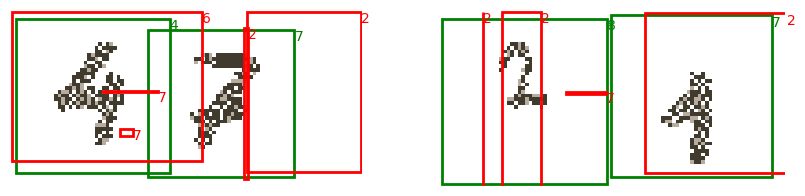

In [12]:
# 引入了非极大抑制
from torchvision.ops import nms
def apply_nms(orig_prediction, iou_thresh=0.01):
    # 应用 NMS 来过滤边界框
    keep = nms(orig_prediction['boxes'], orig_prediction['scores'], iou_thresh)
    final_prediction = {
        'boxes': orig_prediction['boxes'][keep],
        'scores': orig_prediction['scores'][keep],
        'labels': orig_prediction['labels'][keep] 
    }
    print(f"labels:{final_prediction['labels']}")
    return final_prediction

def visualize_predictions(model, val_loader, device, num_images=2):
    model.eval()  # 设置模型为评估模式
    images, target_dict = next(iter(val_loader))
    images = [image.to(device) for image in images]
    targets = [{k: v[i].to(device) for k, v in target_dict.items()} for i in range(len(images))]

    with torch.no_grad():
        predictions = model(images)
        # 应用 NMS
        predictions = [apply_nms(pred) for pred in predictions]
    
    # 选择要可视化的图像
    images = images[:num_images]
    predictions = predictions[:num_images]
    targets = targets[:num_images]

    return images, predictions, targets

def show_image_with_boxes(image, target, prediction, ax):
    # 将张量图像转换为numpy格式
    print(f"image shape:{image.shape}")
    image = image.cpu().numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    image = np.clip(image, 0, 1)

    ax.imshow(image)
    ax.axis('off')

    # 真实边界框和标签
    for box, label in zip(target['boxes'].cpu(), target['labels'].cpu()):
        rect = patches.Rectangle(
            (box[0], box[1]), box[2] - box[0], box[3] - box[1],
            linewidth=2, edgecolor='green', facecolor='none'
        )
        ax.add_patch(rect)
        # 显示类别标签
        label_text = f"{label.item()}"  # 获取类别标签
        ax.text(box[2], box[1], label_text, color='green', verticalalignment='top')

    # Debug
    print(f"prediction:{prediction.keys()}")

    # 预测边界框和标签
    for idx, (box, label) in enumerate(zip(prediction['boxes'].cpu(), prediction['labels'].cpu())):
        rect = patches.Rectangle(
            (box[0], box[1]), box[2] - box[0], box[3] - box[1],
            linewidth=2, edgecolor='red', facecolor='none'
        )
        ax.add_patch(rect)
        # 显示类别标签
        label_text = f"{label.item()}"  # 获取类别标签
        ax.text(box[2], box[1], label_text, color='red', verticalalignment='top')




# 获取一些图像和预测
images, predictions, targets = visualize_predictions(model, train_loader, device,num_images=2)
# 绘制图像和预测
fig, axes = plt.subplots(1, len(images), figsize=(10,40))
for img, pred, target, ax in zip(images, predictions, targets, axes):
    target_cpu = {k: v.cpu() for k, v in target.items()}
    pred_cpu = {k: v.cpu() for k, v in pred.items()}
    show_image_with_boxes(img.cpu(), target_cpu, pred_cpu, ax)
plt.show()


# 模型测试

In [ ]:
class TestDataset(Dataset):
    def __init__(self, img_dir, transform=None):
        self.img_names = [img for img in os.listdir(img_dir) if img.endswith('.jpg')]
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.img_names)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_names[idx])
        image = read_image(img_path).float()  # 直接转换为浮点类型
        if self.transform:
            image = self.transform(image)

        return image
    
# 定义测试集的转换
test_transform = transforms.Compose([
    transforms.Grayscale(),
    transforms.Resize((48, 96)),
    transforms.Normalize((0.5,), (0.5,))
])

# 创建测试集
test_dataset = TestDataset(img_dir='A+B/inputs', transform=test_transform)

# 创建测试集 DataLoader
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

## 提交格式

In [ ]:
# 确保输出文件夹存在，
output_dir = 'outputs'
os.makedirs(output_dir, exist_ok=True)

model.eval()  # 设置模型为评估模式
with torch.no_grad():
    for i, images in enumerate(test_loader, start=0):
        images = images.to(device)
        outputs = model(images)

        # 获取预测结果
        _, predicted = torch.max(outputs.data, 1)

        # 将预测结果保存到文本文件
        for idx, pred in enumerate(predicted, start=1):
            with open(os.path.join(output_dir, f'{i*test_loader.batch_size + idx}.txt'), 'w') as file:
                file.write(str(pred.item()))

## 观测模式

In [ ]:
import csv
# 确保输出文件夹存在
output_dir = '.'
os.makedirs(output_dir, exist_ok=True)

# CSV 文件路径
csv_file_path = os.path.join(output_dir, 'predictions.csv')

# 设置模型为评估模式
model.eval()

# 创建CSV文件并写入预测结果
with torch.no_grad(), open(csv_file_path, mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['Image_Index', 'Predicted_Sum'])

    for i, images in enumerate(test_loader, start=0):
        images = images.to(device)
        outputs = model(images)

        # 获取预测结果
        _, predicted = torch.max(outputs.data, 1)

        # 写入每个预测结果
        for idx, pred in enumerate(predicted, start=1):
            image_index = i*test_loader.batch_size + idx
            writer.writerow([image_index, pred.item()])

print(f'Predictions saved to {csv_file_path}')


## test set 可视化

In [ ]:
# 设置展示图片的数量
num_images_to_show = 3

# 确保模型处于评估模式
model.eval()

with torch.no_grad():
    # 从测试集中获取一些图像
    images = next(iter(test_loader))[:num_images_to_show]
    images = images.to(device)
    outputs = model(images)

    # 获取预测结果
    _, predicted = torch.max(outputs, 1)

    # 将图像转移到CPU并转换为numpy数组
    images = images.cpu().numpy()

# 绘制图像和预测结果
for i in range(num_images_to_show):
    plt.subplot(1, num_images_to_show, i+1)
    plt.imshow(np.squeeze(images[i]), cmap='gray')
    plt.title(f'Predicted: {predicted[i]}')
    plt.axis('off')
plt.show()
